<a href="https://colab.research.google.com/github/emzola/machinelearning/blob/master/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classification Problem using Neural Networks and Finger Digits 05 Dataset**

# Import necessary libraries
import necessary libraries and dependencies

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
import zipfile
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

print(tf.__version__)

2.2.0-rc3


## Load data

Load and extract zipped dataset (Fingers-digits-05 dataset)

In [0]:
zipdir = "/content/drive/My Drive/datasets/training_images.zip"

with zipfile.ZipFile(zipdir, 'r') as myzip:
  myzip.extractall()

Load image and extract label from dataset

In [0]:
def load_image(file_path):
    return cv2.imread(file_path)

def extract_label(file_name):
    return 1 if "One" in file_name else 2 if "Two" in file_name else 3 if "Three" in file_name else 4 if "Four" in file_name else 5 if "Five" in file_name else 0

train_path = "./training_images/"
image_files = os.listdir(train_path)
train_images = [load_image(train_path + file) for file in image_files]
train_labels = [extract_label(file) for file in image_files]

In [0]:
def preprocess_image(img, side=128):
    min_side = min(img.shape[0], img.shape[1])
    img = img[:min_side, :min_side]
    img = cv2.resize(img, (side,side))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img / 255.0

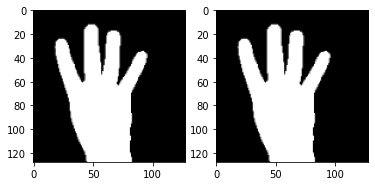

In [6]:
preview_index = 1002
plt.subplot(1,2,1)
plt.imshow(train_images[preview_index])
plt.subplot(1,2,2)
plt.imshow(preprocess_image(train_images[preview_index]), cmap="gray")

In [0]:
for i in range(len(train_images)):
    train_images[i] = preprocess_image(train_images[i])

In [8]:
train_images = np.expand_dims(train_images, axis=-1)
train_labels = np.array(train_labels)
print(train_images.shape, train_labels.shape)

(12006, 128, 128, 1) (12006,)


In [0]:
X = train_images
y = train_labels

In [10]:
np.shape(X)

(12006, 128, 128, 1)

## Draw some images

Each image is of 128x128 pixels. First, construct a matrix from the vector.

In [0]:
def draw_digit(Img, digit_true, digit_pred = ''):
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.reshape(Img, (128, 128)), interpolation = 'nearest')
    plt.text(0, 7, str(digit_true), color = 'b')
    plt.text(0, 1, str(digit_pred), color = 'r')
    plt.set_cmap('binary')    

Draw first 60 images:

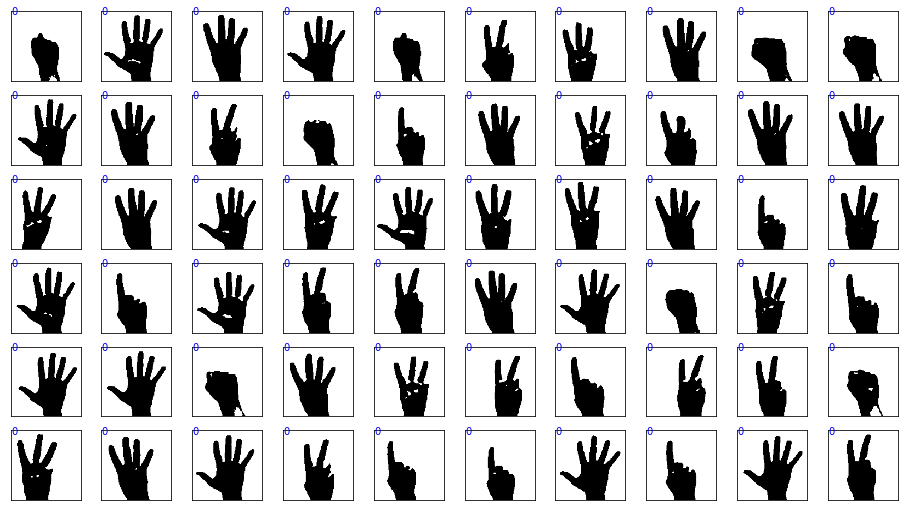

In [12]:
plt.figure(figsize = (16, 9))
for i_subplot in range(60):
    plt.subplot(6, 10, i_subplot + 1)
    draw_digit(X[i_subplot, :], y[i_subplot])

# Break the data into train and test sets
For this we'll use train_test_split. 33% - for the test set, 67% - for the train set.

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

The size of the test and the train sets:

In [14]:
N_train = X_train.shape
N_test = X_test.shape
print(N_train, N_test)

(8044, 128, 128, 1) (3962, 128, 128, 1)


## Train the model

We'll train a simple neural network - multilayer perceptron (MLP)

In [0]:
from sklearn.neural_network import MLPClassifier

First, we define the (hiper) parameters of the Neural Network (in particular, the number of neurons is 100)

In [0]:
mlp_model = MLPClassifier(hidden_layer_sizes = (100,), solver = 'lbfgs', 
                          activation = 'logistic', random_state = 42)

Train the model:

In [0]:
X_train = X_train.reshape(8044,1*128*128)
X_test = X_test.reshape(3962,1*128*128)

In [18]:
mlp_model.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

## Now we can classify:

For example, let's take the 42th image

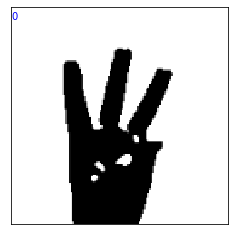

In [19]:
i = 16
Img = X_test[i, :]
dig = y_test[i]
draw_digit(Img, dig)

Which class does the classifier return?

In [20]:
mlp_model.predict([Img])

array([0])

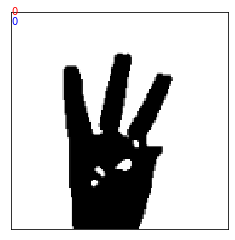

In [21]:
i = 16
Img = X_test[i, :]
dig = y_test[i]
dig_pred = mlp_model.predict([Img])[0]
draw_digit(Img, dig, dig_pred)

## What about the quality of the classifier?

Now let’s input the entire training and the entire test set:

In [0]:
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

Train and test errors:

In [23]:
print(np.mean(y_train != y_train_pred), np.mean(y_test != y_test_pred))

0.0 0.0


# All erroneous cases:

In [24]:
train_error_cases = np.where(y_train != y_train_pred)
test_error_cases = np.where(y_test != y_test_pred)
print(train_error_cases, test_error_cases)

(array([], dtype=int64),) (array([], dtype=int64),)


In [0]:
plt.figure(figsize = (16, 16))
i_subplot = 1 
for i in np.nditer(test_error_cases):
    Img = X_test[i, :]
    digit = y_test[i]
    digit_pred = y_test[i]
    plt.subplot(8, 8, i_subplot)
    draw_digit(Img, digit, digit_pred)
    i_subplot += 1

## Hyperparameter choosing


Find the _optimal_ value for parameter `alpha` (weight decay)

(Instead of using `for` cycle we could use `sklearn.model_selection.GridSearchCV`)

In [0]:
alpha_arr = np.logspace(-3, 2, num=21)
test_err = []
train_err = []
for alpha in alpha_arr:
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (100), 
                              solver = 'lbfgs', activation = 'logistic', 
                              random_state = 42)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

In [27]:
alpha_arr

array([1.00000000e-03, 1.77827941e-03, 3.16227766e-03, 5.62341325e-03,
       1.00000000e-02, 1.77827941e-02, 3.16227766e-02, 5.62341325e-02,
       1.00000000e-01, 1.77827941e-01, 3.16227766e-01, 5.62341325e-01,
       1.00000000e+00, 1.77827941e+00, 3.16227766e+00, 5.62341325e+00,
       1.00000000e+01, 1.77827941e+01, 3.16227766e+01, 5.62341325e+01,
       1.00000000e+02])

Draw the graphs of a dependence of the train and test errors on `alpha` 

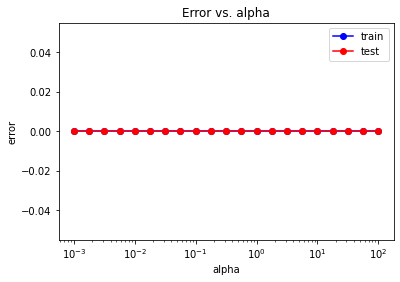

In [28]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'test')
#plt.xlim([np.max(alpha_arr), np.min(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()
pass

Minimum values of the errors:

In [29]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)

print(min_train_err, min_test_err)

0.0 0.0


Optimum value of the `alpha`:

In [30]:
alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt)

[1.00000000e-03 1.77827941e-03 3.16227766e-03 5.62341325e-03
 1.00000000e-02 1.77827941e-02 3.16227766e-02 5.62341325e-02
 1.00000000e-01 1.77827941e-01 3.16227766e-01 5.62341325e-01
 1.00000000e+00 1.77827941e+00 3.16227766e+00 5.62341325e+00
 1.00000000e+01 1.77827941e+01 3.16227766e+01 5.62341325e+01
 1.00000000e+02]


In [0]:
alpha_opt = alpha_opt[0]

## The classifier for *optimal* value of `alpha`:

Repeat the training:

In [33]:
mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (100,),
                          solver = 'lbfgs', activation = 'logistic', random_state = 42)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
print(np.mean(y_train != y_train_pred))
print(np.mean(y_test != y_test_pred))

0.0
0.0


## Confusion matrix

Confusion matrix allows us to estimate the quality of the classifier. The rows of the matrix correspond to the real classes. The columns to the predicted classes. At the intersection of the row `i` and the column` j` is the number of objects of the `i`th class, classified by the classifier as the `j`th class. In Python, all indices are numbered beginning from 0.

In [34]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_test_pred))

[[3962]]


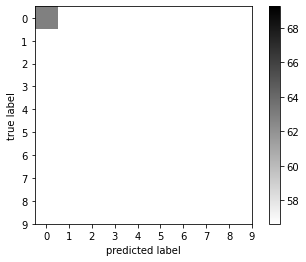

In [35]:
M = confusion_matrix(y_test, y_test_pred)
M = np.sqrt(M)
plt.imshow(M, interpolation = 'nearest')
plt.set_cmap('binary')
plt.xticks(range(10))
plt.yticks(range(10))
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.colorbar()
pass

In [0]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(y_test, y_test_pred) # Since Version 0.22

## Other metrics of quality

In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3962

    accuracy                           1.00      3962
   macro avg       1.00      1.00      1.00      3962
weighted avg       1.00      1.00      1.00      3962



${\rm error} = \frac{{\rm FP} + {\rm FN}}{{\rm TP} + {\rm TN} + {\rm FP} + {\rm FN}}$ 

${\rm accuracy} = \frac{{\rm TP} + {\rm TN}}{{\rm TP} + {\rm TN} + {\rm FP} + {\rm FN}} = 1 - {\rm error}$ 

${\rm precision} = \frac{{\rm TP}}{{\rm FP}+{\rm TP}}$ 

${\rm recall} = {\rm TPR} = \frac{{\rm TP}}{{\rm FN}+{\rm TP}}$ 

$F_1 = 2\cdot\frac{{\rm precision}\cdot{\rm recall}}{{\rm precision}+{\rm recall}}$ 



